# Relationship between APs and dendritic spikes across an oscillatory burst

The simulations had either: 
1. Bursts of rhythmic inhibition either at the soma (64 Hz) or dendrites (16 Hz)
2. Poisson excitation at the soma and dendrites

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike
4. period of the oscillatory burst (early, middle, late)

In [1]:
import os
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal as ss
from src.bin_rhythmic_burst_files import bin_rhythmic_burst_files
from src.bin_serser import bin_serser
from src.cc_serpt import cc_serpt
from src.cc_ptpt import cc_ptpt
from src.sta_files import sta_files
from src.load_caspks_csv import load_caspks_csv
from src.load_spike_h5 import load_spike_h5
from src.cc_serser import cc_serser
from src.count_dendevt_files import count_dendevt_files

# Analysis parameters


In [2]:
samps_per_ms = 10 
sim_win = [0, 3000000] # beginning and start points of simulation in samples
sta_win = [-100, 100] # multiply by step to get window in milliseconds
sta_step = 1 # binning step for each point in the STA
step = 1 * samps_per_ms # number of simulation steps for creating the dendritic 
                        # event occurrence series

#### List files to be processed

In [3]:
# locate simulation files
root_dir = 'Y:\\DendCompOsc\\'
sim_dict = [{'SimName': 'burst_64hz_prox',
            'RootDir': root_dir,
            'SimDir': 'output_burst_64Hz_prox',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'BurstModFile': 'modulatory_trace_64Hz.npy',
            'APFile': 'spikes.h5'},
            ]

sim_df = pd.DataFrame(sim_dict)
sim_df.set_index('SimName', inplace=True)
sim_df



,RootDir,SimDir,CaFileSuffix,NaFileSuffix,NMDAFileSuffix,BurstModFile,APFile
SimName,,,,,,,
burst_64hz_prox,Y:\DendCompOsc\,output_burst_64Hz_prox,_ca.csv,_na.csv,_nmda.csv,modulatory_trace_64Hz.npy,spikes.h5


In [4]:
sim_df['NMDAFile'] = sim_df.apply(lambda x: os.path.join(x['RootDir'], x['SimDir'], x['SimDir'] + x['NMDAFileSuffix']), axis=1)
sim_df['CaFile'] = sim_df.apply(lambda x: os.path.join(x['RootDir'], x['SimDir'], x['SimDir'] + x['CaFileSuffix']), axis=1)
sim_df['NaFile'] = sim_df.apply(lambda x: os.path.join(x['RootDir'], x['SimDir'], x['SimDir'] + x['NaFileSuffix']), axis=1)

#### Generate STAs for dendritic spikes

In [136]:
lag_sta = []
for sim_name, sim_dict in sim_df.iterrows():
    # load the modulatory trace
    mod_path = os.path.join(sim_dict['RootDir'], sim_dict['SimDir'], sim_dict['BurstModFile'])
    burst_mod = np.load(mod_path)

    
    # identify points where the burst peaks occur
    # defined as the trough nearest to the peak in amplitude of the modulatory trace
    h_mod = ss.hilbert(burst_mod-np.mean(burst_mod))
    h_mod_amp = np.abs(h_mod)
    h_mod_phase = np.angle(h_mod)
    amp_peaks = ss.find_peaks(h_mod_amp, distance=200, height=0.5)[0]
    osc_troughs = ss.find_peaks(-h_mod_phase, distance=10)[0]

    # create a series of the unwrapped phase of the modulatory trace, with NaNs for non-bursting periods
    burst_ph_ser = np.ones(burst_mod.size)*np.nan
    for i, p in enumerate(amp_peaks):
        burst_mid = np.argmin(np.abs(osc_troughs-p))
        burst_start = osc_troughs[burst_mid-4]
        burst_end = osc_troughs[burst_mid+4]
        burst_ph_ser[burst_start:burst_end] = np.unwrap(h_mod_phase[burst_start:burst_end])

    burst_ph_ser = burst_ph_ser[:int(sim_win[1]/10)]
    burst_ph_bins = np.arange(-np.pi, (np.pi*2*8)-np.pi, np.pi/4)

    # analyze entrainment of action potentials
    ap_path = os.path.join(sim_dict['RootDir'], sim_dict['SimDir'], sim_dict['APFile'])
    ap = load_spike_h5(ap_path)/samps_per_ms # divide by 10 to convert to ms
    ap_hist = np.histogram(ap, bins=np.arange(sim_win[0]/samps_per_ms,sim_win[1]/samps_per_ms))[0]*1000

    proc_temp = {'sim_name': sim_name}
    proc_temp['ph_bin'] = burst_ph_bins
    proc_temp['ap_bin'] = bin_serser(ap_hist, burst_ph_ser[:ap_hist.size],  burst_ph_bins)
    proc_temp['mod_bin'] = bin_serser(burst_mod[:ap_hist.size], burst_ph_ser[:ap_hist.size],  burst_ph_bins)
    proc_temp['ca_bin'] = bin_rhythmic_burst_files(sim_dict['CaFile'], burst_ph_ser, step, sim_win, burst_ph_bins)
    proc_temp['nmda_bin'] = bin_rhythmic_burst_files(sim_dict['NMDAFile'], burst_ph_ser, step, sim_win, burst_ph_bins)
    proc_temp['na_bin'] = bin_rhythmic_burst_files(sim_dict['NaFile'], burst_ph_ser, step, sim_win, burst_ph_bins)

    lag_sta.append(proc_temp)

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)


In [47]:
zscore = lambda x, y: (x - np.mean(x,axis=y).reshape(-1,1))/np.std(x,axis=y).reshape(-1,1)

In [137]:
def plot_dendevt_ph(data, evt='nmda_bin', **kwargs):
    fig, ax = plt.subplots(2,1,figsize=(7, 4))

    ph = ax[0].pcolormesh(data['ph_bin'][:-1],range(9,0,-1),
                      data[evt].loc['apic', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',**kwargs)
    fig.colorbar(ph, ax=ax[0])
    ax[0].twinx().plot(data['ph_bin'], data['mod_bin']['values'], color='r')
    ax[0].set_xlim([data['ph_bin'][0], data['ph_bin'][-1]-0.5])
    ax[0].set_title(evt + ' apical dendrite')
    ax[0].set_xlabel('Phase (radians)')

    ph = ax[1].pcolormesh(data['ph_bin'][:-1],range(9,0,-1),
                      data[evt].loc['dend', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',**kwargs)
    fig.colorbar(ph, ax=ax[1])
    ax[1].twinx().plot(data['ph_bin'], data['mod_bin']['values'], color='r')
    ax[1].set_xlim([data['ph_bin'][0], data['ph_bin'][-1]-0.5])
    ax[1].set_title(evt + ' basal dendrite')
    ax[1].set_xlabel('Phase (radians)')
    fig.tight_layout()
    return fig, ax


In [138]:
# plotting functions
def plot_ap_stairs(data, ax=None):
        if ax is None:
                fig, ax = plt.subplots()

        ax.stairs(data['ap_bin']['values'][:-1], data['ph_bin'], baseline=0, fill=True)
        ax.twinx().plot(data['ph_bin'], data['mod_bin']['values'],color='r', linestyle=':')
        return ax

def plot_ca_stairs(data, ax=None):
        if ax is None:
                fig, ax = plt.subplots()

        ax.stairs(np.mean(data['ca_bin'].loc['apic', 'ph_bin'][:,1:],axis=0), data['ph_bin'], baseline=0, fill=True)
        ax.twinx().plot(data['ph_bin'], data['mod_bin']['values'],color='r', linestyle=':')
        return ax

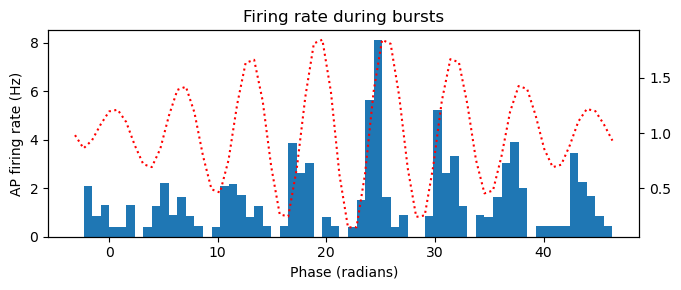

In [142]:
fig, ax = plt.subplots(figsize=(7,3))
plot_ap_stairs(lag_sta[0], ax=ax)
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('AP firing rate (Hz)')
ax.set_title('Firing rate during bursts')
fig.tight_layout()
plt.savefig('../figures/Burst_64Hz_AP.pdf')

Text(0.5, 1.0, 'Calcium spikes in apical dendrite during bursts')

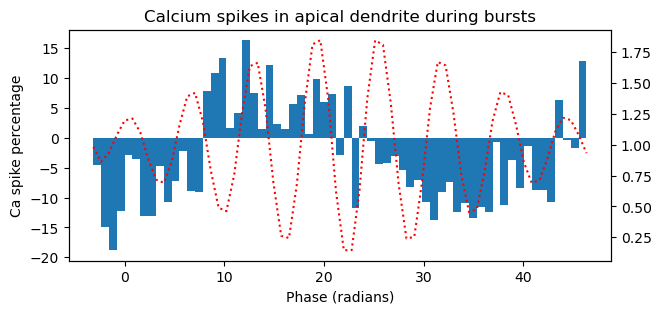

In [135]:
fig, ax = plt.subplots(figsize=(7,3))
plot_ca_stairs(lag_sta[0], ax=ax)
ax.set_xlabel('Phase (radians)')
ax.set_ylabel('Ca spike percentage')
ax.set_title('Calcium spikes in apical dendrite during bursts')

(<Figure size 700x400 with 6 Axes>,
 array([<Axes: title={'center': 'nmda_bin apical dendrite'}, xlabel='Phase (radians)'>,
        <Axes: title={'center': 'nmda_bin basal dendrite'}, xlabel='Phase (radians)'>],
       dtype=object))

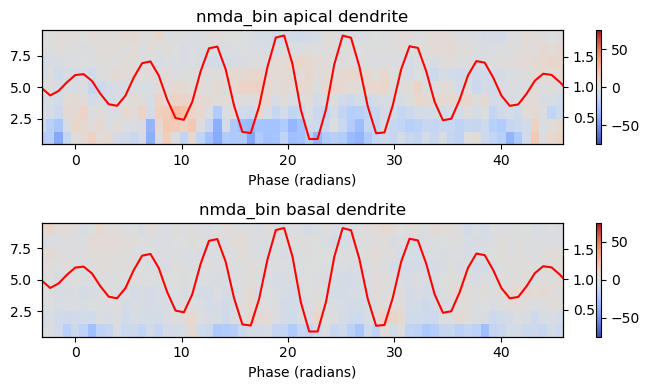

In [95]:
plot_dendevt_ph(lag_sta[0], dendevt='nmda_bin', vmin=-75, vmax=75)

(<Figure size 700x400 with 6 Axes>,
 array([<Axes: title={'center': 'na_bin apical dendrite'}, xlabel='Phase (radians)'>,
        <Axes: title={'center': 'na_bin basal dendrite'}, xlabel='Phase (radians)'>],
       dtype=object))

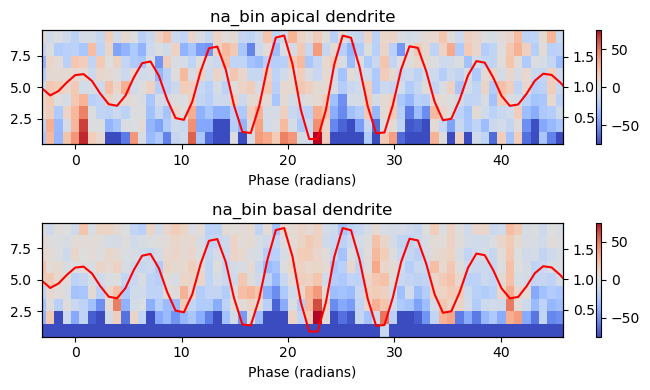

In [94]:
plot_dendevt_ph(lag_sta[0], dendevt='na_bin', vmin=-75, vmax=75)

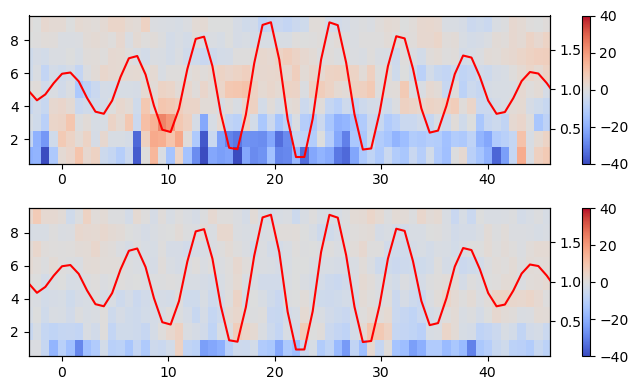

In [81]:
ph = ax[0].pcolormesh(lag_sta[0]['ph_bin'][:-1],range(9,0,-1),
                      lag_sta[0]['nmda_bin'].loc['apic', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',vmin=-40,vmax=40)
fig.colorbar(ph, ax=ax[0])
ax[0].twinx().plot(lag_sta[0]['ph_bin'], lag_sta[0]['mod_bin']['values'], color='r')
ax[0].set_xlim([lag_sta[0]['ph_bin'][0], lag_sta[0]['ph_bin'][-1]-0.5])
ph = ax[1].pcolormesh(lag_sta[0]['ph_bin'][:-1],range(9,0,-1),
                      lag_sta[0]['nmda_bin'].loc['dend', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',vmin=-40,vmax=40)
fig.colorbar(ph, ax=ax[1])
ax[1].twinx().plot(lag_sta[0]['ph_bin'], lag_sta[0]['mod_bin']['values'], color='r')
ax[1].set_xlim([lag_sta[0]['ph_bin'][0], lag_sta[0]['ph_bin'][-1]-0.5])
fig.tight_layout()


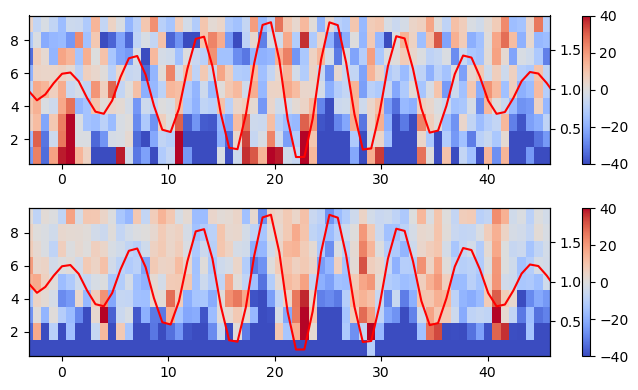

In [82]:
fig, ax = plt.subplots(2,1,figsize=(7, 4))
ph = ax[0].pcolormesh(lag_sta[0]['ph_bin'][:-1],range(9,0,-1),
                      lag_sta[0]['na_bin'].loc['apic', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',vmin=-40,vmax=40)
fig.colorbar(ph, ax=ax[0])
ax[0].twinx().plot(lag_sta[0]['ph_bin'], lag_sta[0]['mod_bin']['values'], color='r')
ax[0].set_xlim([lag_sta[0]['ph_bin'][0], lag_sta[0]['ph_bin'][-1]-0.5])
ph = ax[1].pcolormesh(lag_sta[0]['ph_bin'][:-1],range(9,0,-1),
                      lag_sta[0]['na_bin'].loc['dend', 'ph_bin'][:-1,1:],
                      cmap='coolwarm',vmin=-40,vmax=40)
fig.colorbar(ph, ax=ax[1])
ax[1].twinx().plot(lag_sta[0]['ph_bin'], lag_sta[0]['mod_bin']['values'], color='r')
ax[1].set_xlim([lag_sta[0]['ph_bin'][0], lag_sta[0]['ph_bin'][-1]-0.5])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(7, 4))
ph = ax[0].pcolormesh(burst_ph_bins[:-1],range(9,0,-1),lag_sta[0]['nmda_sta'].loc['apic', 'ph_bin'][:-1,1:],cmap='coolwarm',
                      norm=colors.CenteredNorm(vcenter=0))
fig.colorbar(ph, ax=ax[0])
ax[0].twinx().plot(burst_ph_bins, burst_mod_bin['values'], color='r')
ax[0].set_xlim([burst_ph_bins[0], burst_ph_bins[-1]-0.5])
ph = ax[1].pcolormesh(burst_ph_bins[:-1],range(9,0,-1),lag_sta[0]['nmda_sta'].loc['dend', 'ph_bin'][:-1,1:],cmap='coolwarm',
                      norm=colors.CenteredNorm(vcenter=0))
fig.colorbar(ph, ax=ax[1])
ax[1].twinx().plot(burst_ph_bins, burst_mod_bin['values'], color='r')
ax[1].set_xlim([burst_ph_bins[0], burst_ph_bins[-1]-0.5])
fig.tight_layout()

#### Plot percent change in dendritic event occurrence with repect to APs